In [1]:
# use this code if you are running from google colab to mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/fruitpunch_wildlife2

/content/drive/MyDrive/fruitpunch_wildlife2


In [3]:
!conda install -y pytorch==1.8.0 torchvision==0.9.0 cudatoolkit=10.1 -c pytorch
!yes | pip install pandas
!yes | pip install opencv-python
!yes | pip install pyyaml==5.1
!yes | pip install imgaug==0.2.6
!yes | pip install cython
!yes | pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!yes | pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

/bin/bash: conda: command not found
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-c4goc2kl
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-c4goc2kl
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263915 sha256=4bc48e5b0f75d40479584e09c615fe6a1a0e5f62b066ad4eee103daacf0a8b78
  Stored in directory: /tmp/pip-ephem-wheel-cache-pzofjscs/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
ERROR: detectron2 0.4+cu101 has requirement pycocotools>=2.0.2, but you'll have pycocotools 2.0 which is incompatible.
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
Processing /root/.cache/pip/wheels/68/a5/e7/56401832f23d0b2db351c5b682e466cb4841960b086da65e4e/pycocotool

In [4]:
# import some common libraries
import numpy as np
import os
import pandas as pd
from collections import OrderedDict
import cv2
import matplotlib.pyplot as plt
import random
import pickle
import torch
import time
import datetime
import logging
import argparse
import glob
import sys
# import some common detectron2 utilities
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.engine.hooks import HookBase
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.evaluation import print_csv_format

In [5]:
register_coco_instances("wildlife_dataset_test", {}, "data/video_53_sample_1/annotations/instances_default.json", "data/video_53_sample_1/images")

In [6]:
print("########################################Configuration############################")
cfg = get_cfg()
print(cfg)
print("##################################################################################")
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
#cfg.DATASETS.TRAIN = ("wildlife_dataset_train",)
#cfg.DATASETS.TEST = ("wildlife_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo

# Solver options
cfg.SOLVER.BASE_LR = 0.001 # Base learning rate
cfg.SOLVER.IMS_PER_BATCH = 1  # Lower to reduce memory usage (1 is the lowest)
cfg.SOLVER.WARMUP_ITERS = 100  # Warmup iterations to linearly ramp learning rate from zero
cfg.SOLVER.MAX_ITER = 10  # Maximum number of iterations \
# Adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (100, 200)  # Iterations at which to decay learning rate
cfg.SOLVER.GAMMA = 0.5  # Learning rate decay # previous 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.TEST.EVAL_PERIOD = 20  # evaluation once after 20 iterations on the cfg.DATASETS.TEST, which is the Validation set



output_path = cfg.OUTPUT_DIR
print("Files in output directory:::", os.listdir(output_path))

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.91  # set the testing threshold for this model

########################################Configuration############################
CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ()
  TRAIN: ()
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (800,)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32, 64, 128, 256, 512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
    IN_FEATURE

############Inference##############
Number of test images: 1344
Human instances found in all test images: [3, 3, 2, 2, 4, 5, 3, 4, 3, 2, 4, 2, 1, 2, 3, 3, 2, 2, 3, 3, 3, 2, 4, 5, 4, 4, 3, 4, 4, 3, 4, 4, 3, 3, 2, 2, 4, 3, 5, 4, 3, 4, 4, 3, 2, 3, 4, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 1, 1, 1, 2, 3, 3, 3, 2, 4, 0, 0, 1, 2, 1, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 1, 3, 1, 2, 2, 2, 3, 3, 0, 1, 2, 2, 3, 2, 3, 1, 2, 2, 1, 1, 4, 3, 3, 3, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 3, 1, 3, 2, 1, 2, 2, 3, 2, 3, 1, 1, 2, 3, 2, 3, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,

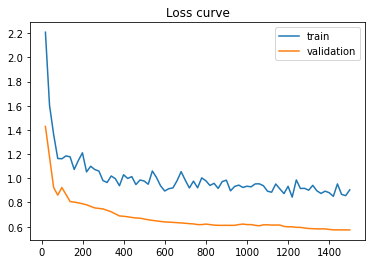

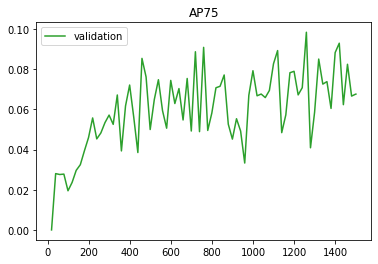

In [14]:
print("############Inference##############")

test_metadata = MetadataCatalog.get("wildlife_dataset_test")
predictor = DefaultPredictor(cfg)

counter = 0
instances = []
for imageName in glob.glob("data/video_53_sample_1/images" + '/*PNG'):
    counter = counter + 1
    im = cv2.imread(imageName)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=0.8
                   )
    l = len(outputs["instances"])
    instances.append(l)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite("./output/inference_" + str(counter) + ".png", out.get_image()[:, :, ::-1])

print("Number of test images:", len(instances))
print("Human instances found in all test images:", instances)

s = sum(instances)
print("Total number of instances found in all images:::", s)

# Metrics calculation
print("#######Metrics##########")

metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
print(mdf)
mdf.to_csv('./output/metrics.csv')

# Plot loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
# plt.show()
plt.savefig("./output/val_vs_train_loss.png")

# AP75 plot
fig, ax = plt.subplots()
mdf3 = mdf[~mdf["bbox/AP75"].isna()]
ax.plot(mdf3["iteration"], mdf3["bbox/AP75"] / 100., c="C2", label="validation")
ax.legend()
ax.set_title("AP75")
# plt.show()
plt.savefig("./output/AP75.png")